In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)


#from csr2d.kick2 import csr2d_kick_calc, csr1d_steady_state_kick_calc

from csr2d.core2 import psi_x_no_phi
from csr2d.kick2 import green_meshes_no_phi
from csr2d.convolution import fftconvolve2

import time
import h5py

import concurrent.futures as cf


import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Chris's parameters

In [2]:
gamma = 500
rho = 1.0 # Bend radius in m

# Total charge
Nb = 6.25e9
Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

sigma_x  = 10e-6
sigma_z  = 10e-6

In [13]:
psi_x_no_phi(-2*sigma_z, 2*sigma_x, beta)

1.306828578410685

## code

In [3]:
# Bypassing the beam, use smooth Gaussian distribution

def lamb_2d(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2)
def lamb_2d_prime(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2) * (-z / sigma_z**2)

In [6]:
nz = 64
nx = 64

nz = 512
nx = 512

nz = 2501
nx = 2501


zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
zm, xm = np.meshgrid(zvec, xvec, indexing='ij')

lambda_grid_filtered_prime = lamb_2d_prime(zm,xm)

dz = (10*sigma_z) / (nz - 1)
dx = (10*sigma_x) / (nx - 1)

psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes_no_phi(nz, nx, dz, dx, rho=rho, beta=beta)  

conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

Ws_grid = (beta ** 2 / abs(rho)) * (conv_s) * (dz * dx)
Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)



x_observe = 0
x_observe_index = np.argmin(np.abs(xvec - x_observe))
print('x_observe_index :', x_observe_index )

#zvec_64 = zvec
#Wx_x0_64 = Wx_grid[:,x_observe_index]
#zvec_512 = zvec
#Wx_x0_512 = Wx_grid[:,x_observe_index]

zvec_2048 = zvec
Wx_x0_2048 = Wx_grid[:,x_observe_index]

x_observe_index : 1250


In [7]:
Wx_x0_2048[1250]

270355.5391277301

Text(0.5, 1.0, 'Wx(z) along x=0 mm')

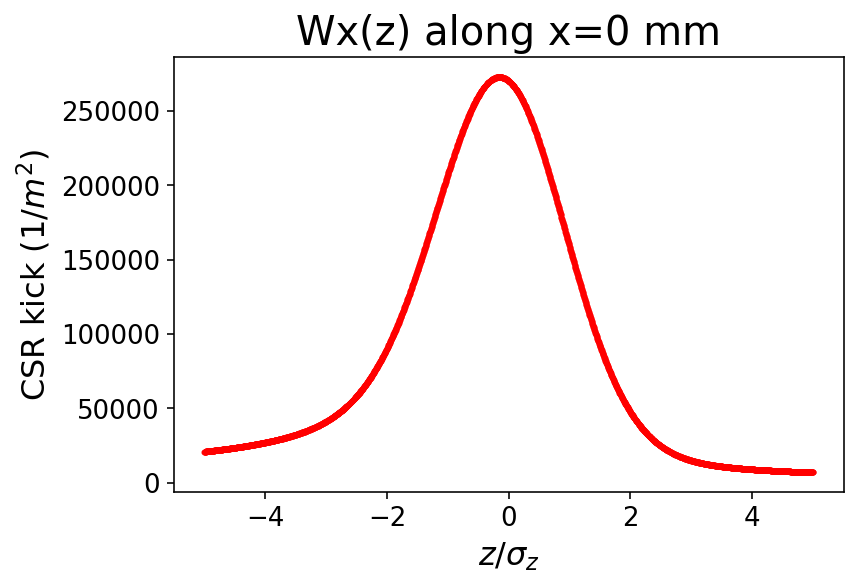

In [12]:
plt.scatter(zvec/sigma_z, Wx_grid[:,x_observe_index], color='red', label='$\phi$=', zorder=10, s=4)

plt.xlabel(r'$z/\sigma_z$', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Wx(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)

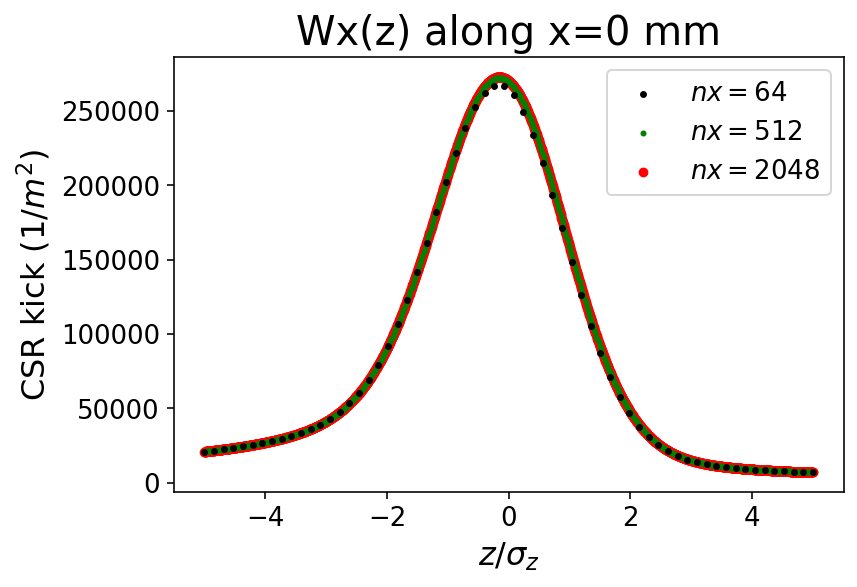

In [67]:
#plt.scatter(zvec_64/sigma_z, Wx_x0_64, color='black', label='$nx=64$', zorder=20, s=6)
#plt.scatter(zvec_512/sigma_z, Wx_x0_512, color='green', label='$nx=512$', zorder=15, s=4)
#plt.scatter(zvec_2048/sigma_z, Wx_x0_2048, color='red', label='$nx=2048$', zorder=10, s=15)


#plt.xlabel(r'$z/\sigma_z$', fontsize=16)
#plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
#plt.title('Wx(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
#plt.legend()

In [69]:
# Save the beam if needed
#haha = np.array(list(zip(zvec_2048/sigma_z,Wx_x0_2048)))
#np.savetxt("Wx_no_phi_Chris_parameter_nx2048.dat",haha)

Text(0.5, 0.92, '$W_x$ benchmarking')

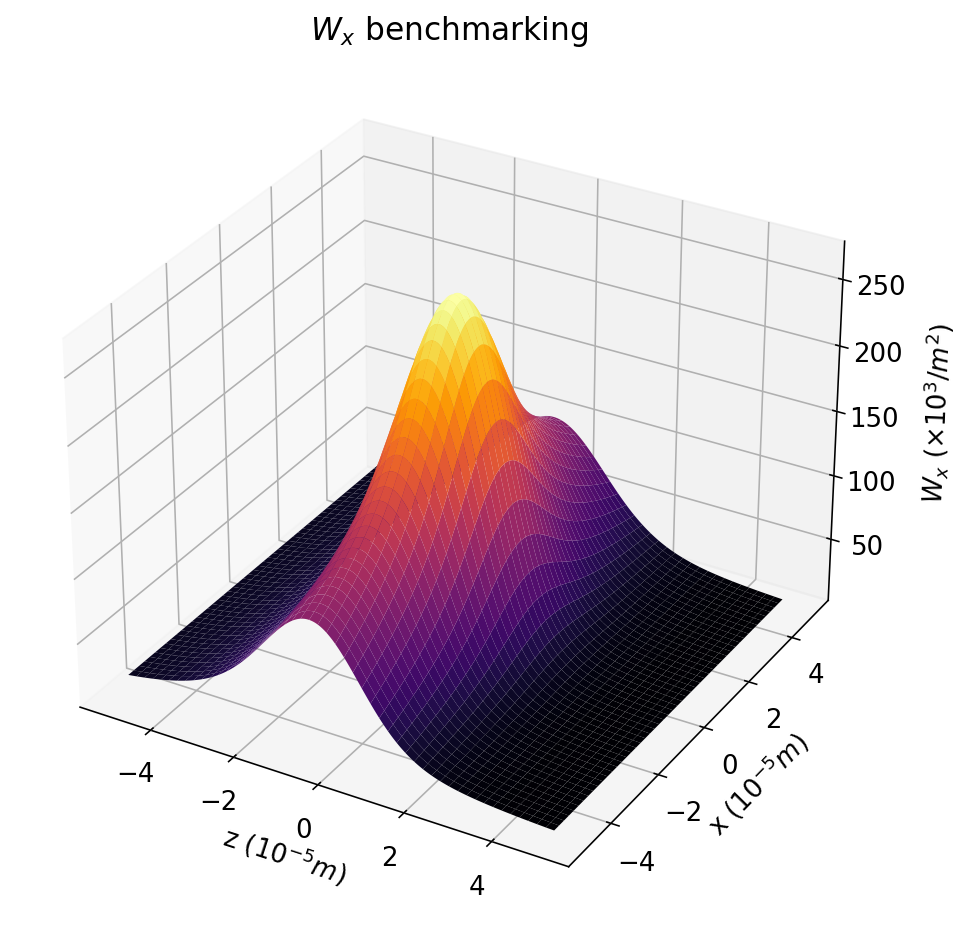

In [13]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, Wx_grid*1e-3 , cmap='inferno', zorder=1)

# plotting the theory curve
#zline = np.linspace(min(zvec), max(zvec), 1000)
#xline = np.zeros(len(zline))
#fline = (-4.0/rho)*np.exp(-(zline/sigma_z)**2/2)/np.sqrt(2*np.pi)/sigma_z
#ax.plot3D(zline*1e5, xline*1e5, fline*1e-3, 'blue', linewidth=5, zorder=3, alpha=0.3)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

#ax.azim = 90

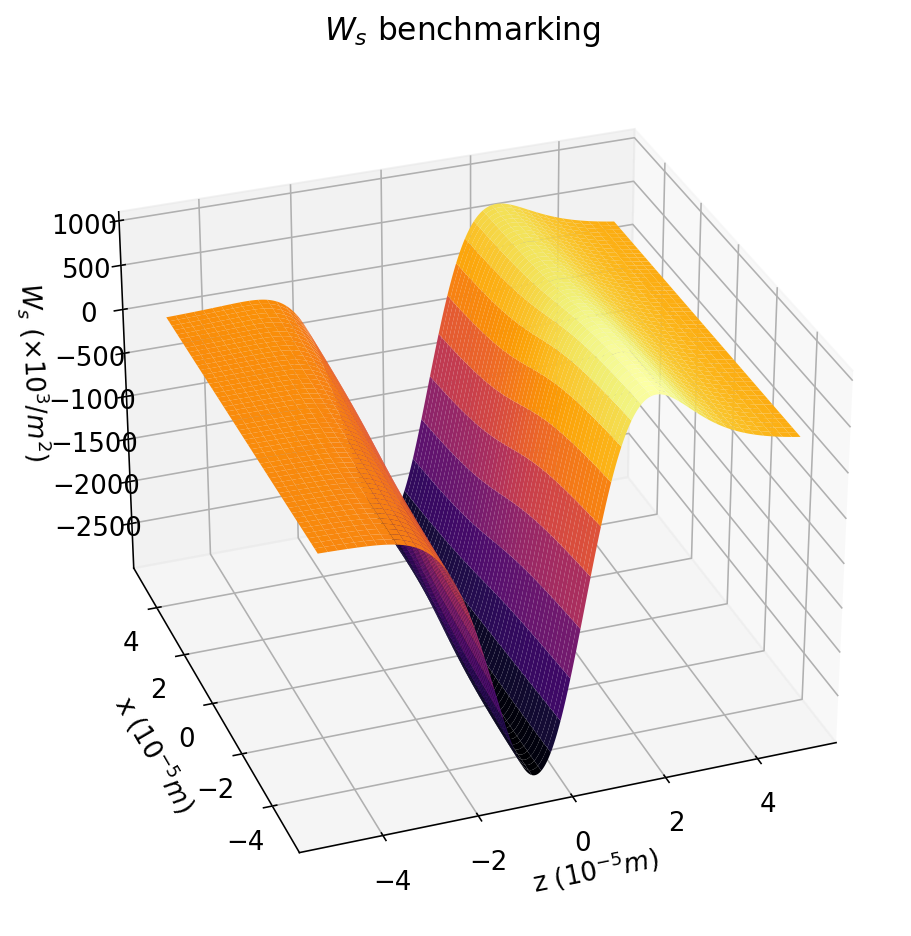

In [14]:
Z, X = np.meshgrid(zvec, xvec, indexing='ij')

# plotting the surface from numerical computation
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z*1e5, X*1e5, Ws_grid*1e-3 , cmap='inferno', zorder=1)

# plotting the theory curve
#zline = np.linspace(min(zvec), max(zvec), 1000)
#xline = np.zeros(len(zline))
#fline = (-4.0/rho)*np.exp(-(zline/sigma_z)**2/2)/np.sqrt(2*np.pi)/sigma_z
#ax.plot3D(zline*1e5, xline*1e5, fline*1e-3, 'blue', linewidth=5, zorder=3, alpha=0.3)


ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_s$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_s$ benchmarking')

ax.azim = 250

# Checking the root finder

In [1]:
from csr2d.core2 import alpha_exact, alpha_exact_case_B_brentq

In [33]:
gamma = 500
beta = (1-1/gamma**2)**(1/2)

nz = 250
nx = 250

sigma_x  = 10e-6
sigma_z  = 10e-6

zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
zm, xm = np.meshgrid(zvec, xvec, indexing='ij')


In [34]:
# Can be slow ( not jitted )
aa = alpha_exact(zm, xm, beta)

In [35]:
aa_brentq = alpha_exact_case_B_brentq(zm, xm, beta)

In [71]:
diff = np.abs(( aa_brentq - aa)/aa) * 100

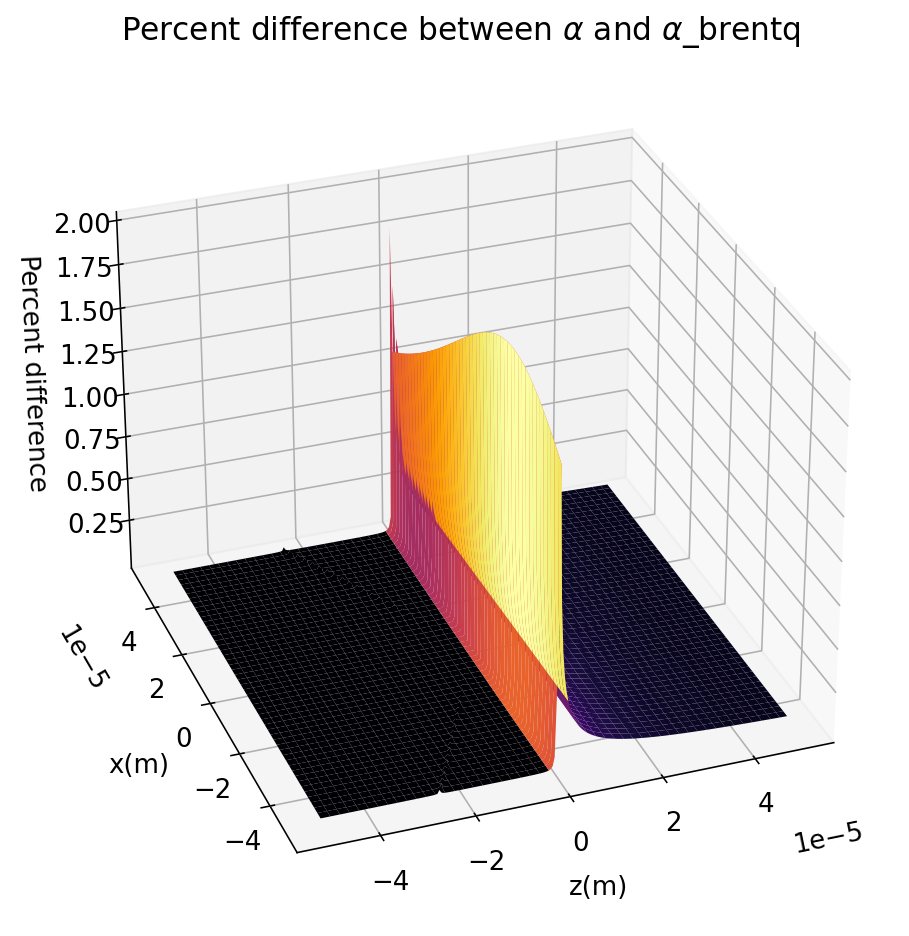

In [72]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zm, xm, diff, cmap='inferno', zorder=1)


ax.set_xlabel(r'z(m)', labelpad = 10)
ax.set_ylabel(r'x(m)', labelpad = 10)
ax.set_zlabel(r'Percent difference', labelpad = 18)
ax.zaxis.labelpad = 10
ax.set_title(r'Percent difference between $\alpha$ and $\alpha$_brentq')

ax.azim = 250

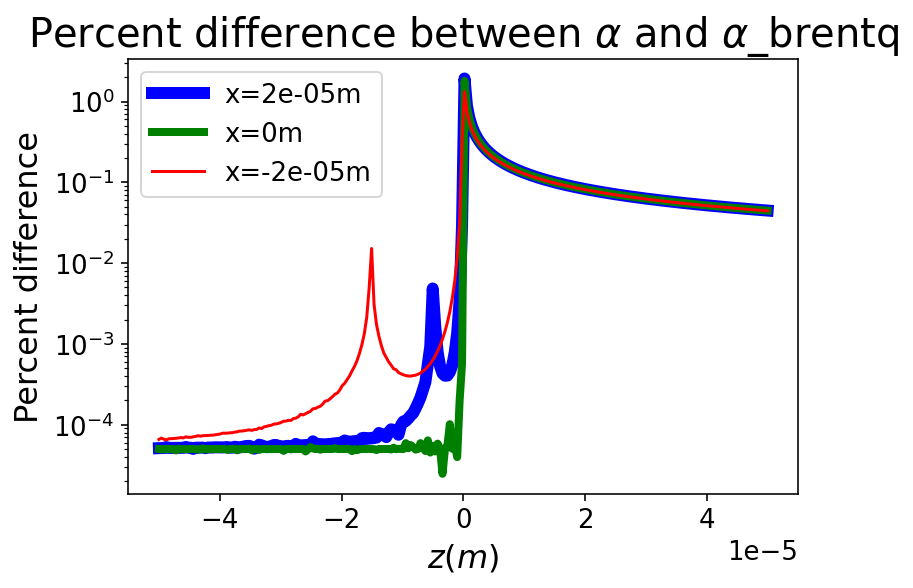

In [73]:
x_o = 2*sigma_x
xix = np.argmin(np.abs(xvec - x_o))
plt.plot(zvec, diff[:, 100], label= f'x={x_o}m', c='blue', linewidth=6)
plt.yscale('log')

x_o = 0
xix = np.argmin(np.abs(xvec - x_o))
plt.plot(zvec, diff[:, xix], label= f'x={x_o}m', c='green', linewidth=4)


x_o = -2*sigma_x
xix = np.argmin(np.abs(xvec - x_o))
plt.plot(zvec, diff[:, 200], label= f'x={x_o}m', c='red')

plt.xlabel(r'$z(m)$', fontsize=16)
plt.ylabel('Percent difference', fontsize=16)
plt.title(r'Percent difference between $\alpha$ and $\alpha$_brentq',  fontsize=20)
plt.legend()

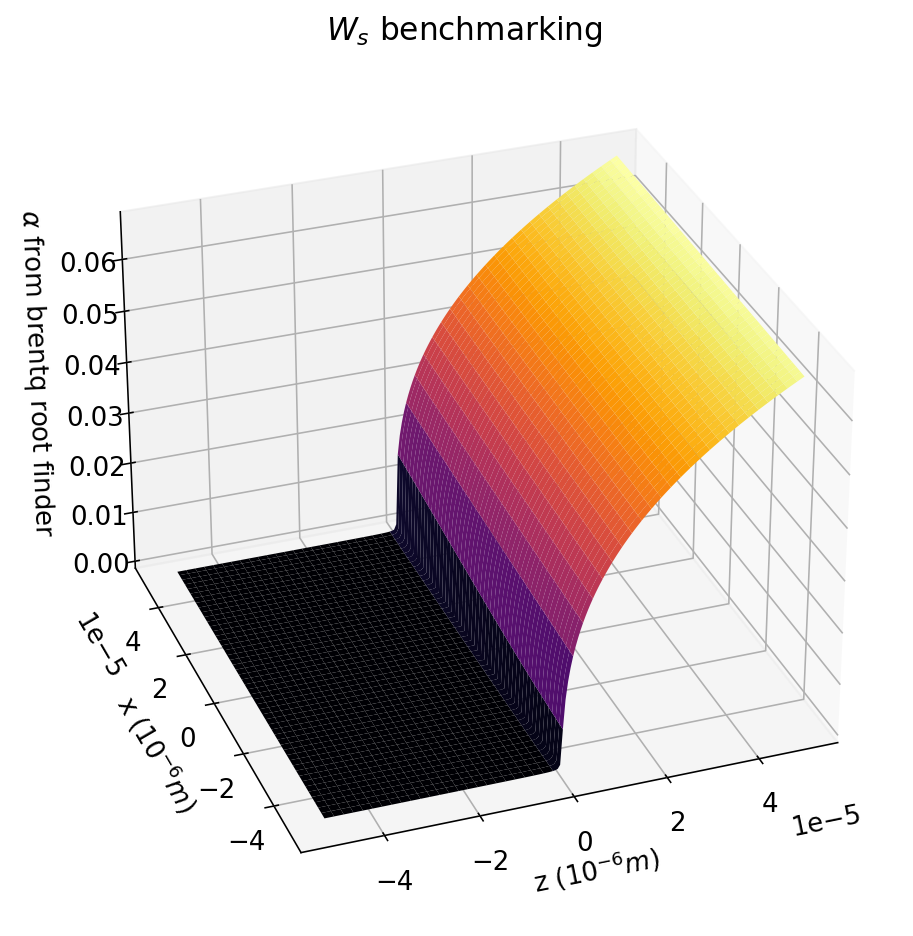

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zm, xm, aa, cmap='inferno', zorder=1)


ax.set_xlabel(r'z $(10^{-6}m)$')
ax.set_ylabel(r'x $(10^{-6}m)$')
ax.set_zlabel(r'$\alpha$ from brentq root finder ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_s$ benchmarking')

ax.azim = 250

In [ ]:
from scipy.ndimage import map_coordinates
map_coordinates(Ws_grid, np.array([zcoord, xcoord]), order=2)

In [1]:
from fast_interp import interp2d
import numpy as np

nx = 50
ny = 37
xv, xh = np.linspace(0, 1,       nx, endpoint=True,  retstep=True)
yv, yh = np.linspace(0, 2*np.pi, ny, endpoint=False, retstep=True)
x, y = np.meshgrid(xv, yv, indexing='ij')

test_function = lambda x, y: np.exp(x)*np.exp(np.sin(y))
f = test_function(x, y)
test_x = -xh/2.0
test_y = 271.43
fa = test_function(test_x, test_y)

interpolater = interp2d([0,0], [1,2*np.pi], [xh,yh], f, k=5, p=[False,True], e=[1,0])
fe = interpolater(test_x, test_y)

print('Error is: {:0.2e}'.format(np.abs(fe-fa)))

/global/homes/w/wlou1991/.conda/envs/cupy/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function '_interp2d_k5'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../GitHub/fast_interp/fast_interp/fast_interp.py", line 385:
@numba.njit(parallel=True)
def _interp2d_k5(f, xout, yout, fout, a, h, n, p, o, lb, ub):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/global/homes/w/wlou1991/.conda/envs/cupy/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'h' of function '_interp2d_k5'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprec

Error is: 4.53e-06
